# PDFs of AVISO errors


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from m2lib22.cstes import labels, zarr_dir

plt.rcParams.update({'font.size':18})

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.37:8787/status,
Dashboard: http://10.148.0.37:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.37:46314,Workers: 0
Dashboard: http://10.148.0.37:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## IMPORT DATA, build dataset

In [3]:
zarr = os.path.join(zarr_dir, 'ds_matchup_gps_05_100.zarr')
ds= xr.open_zarr(zarr)  

In [4]:
ds

<xarray.Dataset>
Dimensions:                                                    (obs: 133258,
                                                                box_x: 80,
                                                                box_y: 40,
                                                                id_comb: 72)
Coordinates: (12/13)
    alti___distance                                            (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    alti___time_difference                                     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
  * box_x                                                      (box_x) float64 ...
  * box_y                                                      (box_y) float64 ...
    drifter_lat                                                (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    drifter_lon                                                (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    ...                                                         ...
    drifter_x                                                  (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    drifter_y                                                  (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
  * id_comb                                                    (id_comb) <U44 ...
    lat                                                        (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    lon                                                        (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    time                                                       (obs) datetime64[ns] dask.array<chunksize=(1000,), meta=np.ndarray>
Dimensions without coordinates: obs
Data variables: (12/355)
    alti_adt_g_grad_x                                          (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    alti_adt_oceantide_dac_g_grad_x                            (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    alti_adt_oceantide_g_grad_x                                (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    alti_denoised_g_grad_x                                     (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    alti_g_grad_x                                              (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    aviso_alti_adt_g_grad_x                                    (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    ...                                                         ...
    sum_co_e5_cstrio_z15_alti_x                                (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    sum_co_e5_cstrio_z15_drifter_x                             (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    sum_co_es_cstrio_z0_alti_x                                 (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    sum_co_es_cstrio_z0_drifter_x                              (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    sum_co_es_cstrio_z15_alti_x                                (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    sum_co_es_cstrio_z15_drifter_x                             (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
Attributes:
    __id:                   SASSA-L3-SLA-SARAL__gps
    __time_coverage_end:    2019-01-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

In [6]:
ds.aviso_alti_matchup_err_sla.min().compute()

<xarray.DataArray 'aviso_alti_matchup_err_sla' ()>
array(0.00406882)

8.03e-3 1.06e-2


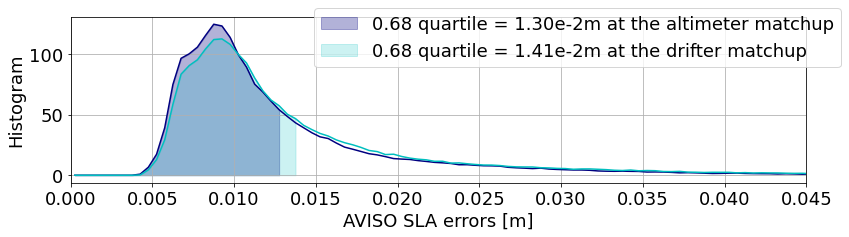

In [48]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,3.5))

b1=np.arange(0,6e-2, 5e-4)

ds_err = histogram(ds.aviso_alti_matchup_err_sla.rename('errsla'), bins=b1, density=True)
ds_errd = histogram(ds.aviso_drifter_matchup_err_sla.rename('errsla'), bins=b1, density=True)
ds_err.plot(ax=ax, color='navy') 
ds_errd.plot(ax=ax, color='c') 
quart = ds.aviso_alti_matchup_err_sla.chunk(dict(obs=-1)).quantile(0.68).compute()
quartd = ds.aviso_drifter_matchup_err_sla.chunk(dict(obs=-1)).quantile(0.68).compute()
mean =  ds.aviso_alti_matchup_err_sla.mean().compute()
meand =  ds.aviso_drifter_matchup_err_sla.mean().compute()
std =  ds.aviso_alti_matchup_err_sla.std().compute()
stdd =  ds.aviso_drifter_matchup_err_sla.std().compute()
ax.grid()

#68%
ax.fill_between(x= ds_err.errsla_bin, y1=ds_err , 
        where= (0 < ds_err.errsla_bin)&(ds_err.errsla_bin < quart),
        color= "navy",
        alpha= 0.3,
        label=f'0.68 quartile = {np.format_float_scientific(quart, precision = 2, exp_digits=1)}m at the altimeter matchup')
ax.fill_between(x= ds_errd.errsla_bin, y1=ds_errd , 
        where= (0 < ds_errd.errsla_bin)&(ds_errd.errsla_bin < quartd),
        color= "c",
        alpha= 0.2,
        label=f'0.68 quartile = {np.format_float_scientific(quartd, precision = 2, exp_digits=1)}m at the drifter matchup')
#ax.axvline(ds.aviso_alti_matchup_err_sla.mean().compute(), color='navy', ls='--', label=f'mean = {np.format_float_scientific(mean, precision = 2, exp_digits=1)}m at the altimeter matchup')
#ax.axvline(ds.aviso_drifter_matchup_err_sla.mean().compute(), color='c', ls='--', label=f'mean = {np.format_float_scientific(meand, precision = 2, exp_digits=1)}m at the drifter matchup')
#ax.set_xticks(list(ax.get_xticks()) + [ds.aviso_alti_matchup_err_sla.chunk(dict(obs=-1)).quantile(0.68).compute()])
ax.set_ylabel('Histogram')
ax.set_xlabel('AVISO SLA errors [m]')
ax.set_xlim(0,0.045)
fig.legend()
fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
print(np.format_float_scientific(std, precision = 2, exp_digits=1), np.format_float_scientific(stdd, precision = 2, exp_digits=1))

In [49]:
cluster.close()

AssertionError: Status.running

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
